# Analysis of baseline differences between ECT and MST treatment groups

## imports

In [40]:
import numpy as np
import scipy.io as sio
import pandas as pd
import h5py as h5

import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from statsmodels.formula.api import ols
from pingouin import corr, ttest

from sklearn import linear_model
from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS
from sklearn.linear_model import LinearRegression

---

# 1) MST

## load EEG features

This cell loads the dataframe with the outputs of the spectral parameterization analysis. Features are then averaged over all electrodes. We are averaging over all electrodes because no spectral features of interest show a characteristic, informative spatial topography. Futhermore, model fits <0.8 are dropped due to poor models fits.

In [2]:
# load dataframe of EEG features
eeg_df = pd.read_csv('../saved_files_appeal/mst_files/mst_all_features.csv', index_col = 0)

# Exclude channels flagged as bad fits
eeg_df_included = eeg_df[eeg_df['exclude']==False]

# features to include in analysis
features = ['delta_cf', 'delta_bw', 'delta_amp', 'delta_bp', 'theta_cf', 'theta_bw', 'theta_amp',
            'theta_bp', 'alpha_cf', 'alpha_bw', 'alpha_amp', 'alpha_bp', 'offset', 'exponent']

# exclude bad fits
eeg_df_included = eeg_df[eeg_df['exclude']==False]

# average across ALL electrodes
eeg_df_mean = pd.DataFrame(eeg_df_included.groupby(['patient', 'pre_post'], as_index=False)[features].mean())

In [3]:
def compute_abundance(df, feature=''):
    """computes abundance as the number of channels containing an oscillation/total channels
    Parameters
    ----------
    Returns
    -------
    """
    features = ['patient','pre_post','channel', feature+'_cf']
    df_osc = pd.DataFrame(df[features])
    df_osc[f'{feature}_present'] = df_osc[feature+'_cf'].notna()
    ch_osc = df_osc.groupby(['patient', 'pre_post'])[f'{feature}_present'].sum().values
    ch_total = df_osc.groupby(['patient', 'pre_post'])['channel'].count().values
    ch_osc_perc = ch_osc/ch_total
    osc_perc_df = pd.DataFrame(df_osc.groupby(['patient', 'pre_post'], as_index=False)[f'{feature}_present'].sum())
    osc_perc_df[f'ch_{feature}_perc'] = ch_osc_perc
    
    return osc_perc_df

In [4]:
delta_perc_df = compute_abundance(eeg_df_included, feature='delta')
theta_perc_df = compute_abundance(eeg_df_included, feature='theta')
alpha_perc_df = compute_abundance(eeg_df_included, feature='alpha')

In [5]:
# merge percentage dfs
perc_df = pd.merge(theta_perc_df, delta_perc_df, how='left', on=['patient', 'pre_post'])
perc_df = pd.merge(perc_df, alpha_perc_df, how='left', on=['patient', 'pre_post'])

In [6]:
# merge perc with main eeg feature df
eeg_df_mean = pd.merge(eeg_df_mean, perc_df, how='left', on=['patient', 'pre_post'])

## convert EEG features dataframe into better format

The ideal dataframe for our analysis has one line for each patient. EEG features are either pre_feature, post_feature, or d_feature.

In [7]:
# pre eeg features
eeg_pre_df_mean = eeg_df_mean[eeg_df_mean['pre_post']=='pre'] 

# post eeg features
eeg_post_df_mean = eeg_df_mean[eeg_df_mean['pre_post']=='post'] 

features = ['delta_cf', 'delta_bw', 'delta_amp', 'delta_bp', 'theta_cf', 'theta_bw', 'theta_amp',
            'theta_bp', 'alpha_cf', 'alpha_bw', 'alpha_amp', 'alpha_bp', 'offset', 'exponent',
            'ch_delta_perc', 'ch_theta_perc', 'ch_alpha_perc']

# difference in eeg features (pre-post)
eeg_diff_df_mean = eeg_df_mean.groupby(['patient'], as_index=False)[features].diff().dropna(0,how='all')
eeg_diff_df_mean['patient'] = eeg_df_mean['patient']

/var/folders/96/g2_ml18s7v1cqm0wh8_8n5bh0000gn/T/ipykernel_40933/668889714.py:12: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only
  eeg_diff_df_mean = eeg_df_mean.groupby(['patient'], as_index=False)[features].diff().dropna(0,how='all')


In [8]:
eeg_pre_df_mean = eeg_pre_df_mean.rename(columns={c: 'pre_'+c for c in eeg_pre_df_mean.columns if c not in ['patient']})
eeg_post_df_mean = eeg_post_df_mean.rename(columns={c: 'post_'+c for c in eeg_post_df_mean.columns if c not in ['patient']})
eeg_diff_df_mean = eeg_diff_df_mean.rename(columns={c: 'diff_'+c for c in eeg_diff_df_mean.columns if c not in ['patient']})


In [9]:
eeg_pre_post = pd.merge(eeg_pre_df_mean, eeg_post_df_mean, on='patient', how='left')
eeg_pre_post_diff = pd.merge(eeg_pre_post, eeg_diff_df_mean, on='patient', how='left')

In [10]:
eeg_pre_post_diff = eeg_pre_post_diff.drop(labels=['pre_pre_post', 'post_pre_post'], axis='columns')

In [11]:
eeg_pre_post_diff

,patient,pre_delta_cf,pre_delta_bw,pre_delta_amp,pre_delta_bp,pre_theta_cf,pre_theta_bw,pre_theta_amp,pre_theta_bp,pre_alpha_cf,...,diff_theta_bp,diff_alpha_cf,diff_alpha_bw,diff_alpha_amp,diff_alpha_bp,diff_offset,diff_exponent,diff_ch_delta_perc,diff_ch_theta_perc,diff_ch_alpha_perc
0,9,2.005953,1.000000,0.146205,-11.321277,5.350125,1.818249,0.406346,-11.572985,9.112030,...,0.217771,-0.192200,1.119524,-0.033322,0.237228,0.507025,0.345650,0.033333,-0.416667,0.000000
1,10,2.453152,1.000000,0.040532,-12.365095,6.482045,1.017572,0.186566,-12.690452,9.555304,...,0.271554,-0.243517,0.389320,0.133247,0.377337,0.261876,0.025480,0.017857,0.071429,0.125000
2,18,2.749999,1.000000,0.000270,-11.664588,5.256693,1.425727,0.347283,-11.836585,8.734414,...,0.134673,-0.024780,0.562352,0.012112,-0.016471,0.042335,0.115917,0.000000,0.266667,0.000000
3,22,NaN,NaN,NaN,-11.830947,6.542572,2.014467,0.452602,-11.993586,9.135260,...,-0.450002,0.006089,-1.981499,0.285625,-0.103030,-0.369752,-0.184502,0.000000,0.000000,0.000000
4,25,NaN,NaN,NaN,-11.694787,6.619938,1.421509,0.362230,-12.026519,8.687937,...,0.323614,-0.800650,-0.613174,-0.779568,-0.284728,0.466595,0.014182,-0.033898,0.118644,0.000000
5,33,NaN,NaN,NaN,-11.528993,5.631176,1.607905,0.454667,-11.381208,8.937167,...,-0.488498,0.058184,-0.219198,0.204019,0.044466,-0.526216,-0.494473,-0.133333,-0.266667,0.000000
6,35,3.937715,1.000000,0.201216,-11.883628,5.972226,2.172916,0.579893,-11.723036,7.923002,...,-0.371153,-0.089036,0.994337,0.103503,0.007112,-0.224031,-0.138135,0.066667,-0.583333,0.466667
7,40,NaN,NaN,NaN,-11.931082,NaN,NaN,NaN,-12.353660,9.481518,...,-0.060564,-0.287408,-0.841394,-0.028574,0.017294,-0.340487,-0.356957,0.000000,0.000000,0.076923
8,46,NaN,NaN,NaN,-11.726602,4.630958,1.658109,0.392234,-11.773041,9.020745,...,-0.025370,-0.023627,-0.105915,0.087367,0.072388,-0.005157,-0.036711,0.000000,-0.116667,0.000000
9,47,3.012010,1.184911,0.202836,-11.998070,5.407184,2.042564,0.173121,-12.393061,8.833356,...,0.344395,-0.626846,0.838933,-0.289977,0.098429,0.266258,0.144388,0.183333,0.033333,0.000000


## load clinical features CSV

This cell loads the dataframes with clinical ratings and demographics. These dataframes are then refactored into a single clinical dataframe with the relevant features included.

In [12]:
MST_clinical = pd.read_csv('../saved_files_appeal/mst_files/mst_clinical_data/MST_clinical.csv')
MST_HAMD = pd.read_csv('../saved_files_appeal/mst_files/mst_clinical_data/MST_HAMD.csv')
exp_df = pd.read_csv('../saved_files_appeal/mst_files/mst_all_features.csv', index_col=0)

# rename columns

MST_HAMD = MST_HAMD[['subject', 'TotalBaseline', 'TotalPost']].copy().rename(columns={'subject': 'patient',
                                                                                'TotalBaseline': 'pre_HAMD',
                                                                                'TotalPost': 'post_HAMD'})
MST_clinical = MST_clinical[['SubjectID', 'x_OfAcuteTxsReceived']].copy().rename(columns={'SubjectID': 'patient',
                                                                                  'x_OfAcuteTxsReceived': 'n_TxsReceived'})

#merge into single dataframe
all_clinical = pd.merge(MST_HAMD, MST_clinical, on='patient', how='outer')

## note about merging clinical and EEG data

Merge dataframes at an ad-hoc basis for the demands of each regression formula 

In [13]:
mst_clin_eeg_df = pd.merge(eeg_pre_post_diff, all_clinical, on='patient', how='left')

---
# 2) ECT

## load EEG features

This cell loads the dataframe with the outputs of the spectral parameterization analysis. Features are then averaged over all electrodes. We are averaging over all electrodes because no spectral features of interest show a characteristic, informative spatial topography. Futhermore, model fits <0.8 are dropped due to poor models fits.

In [14]:
# load dataframe of EEG features
eeg_df = pd.read_csv('../saved_files_appeal/ect_files/ect_all_features.csv', index_col = 0)

# Exclude channels flagged as bad fits
eeg_df_included = eeg_df[eeg_df['exclude']==False]

# features to include in analysis
features = ['delta_cf', 'delta_bw', 'delta_amp', 'delta_bp', 'theta_cf', 'theta_bw', 'theta_amp',
            'theta_bp', 'alpha_cf', 'alpha_bw', 'alpha_amp', 'alpha_bp', 'offset', 'exponent']

# exclude bad fits
eeg_df_included = eeg_df[eeg_df['exclude']==False]

# average across ALL electrodes
eeg_df_mean = pd.DataFrame(eeg_df_included.groupby(['patient', 'pre_post'], as_index=False)[features].mean())

In [15]:
delta_perc_df = compute_abundance(eeg_df_included, feature='delta')
theta_perc_df = compute_abundance(eeg_df_included, feature='theta')
alpha_perc_df = compute_abundance(eeg_df_included, feature='alpha')

In [16]:
# merge percentage dfs
perc_df = pd.merge(theta_perc_df, delta_perc_df, how='left', on=['patient', 'pre_post'])
perc_df = pd.merge(perc_df, alpha_perc_df, how='left', on=['patient', 'pre_post'])

In [17]:
# merge perc with main eeg feature df
eeg_df_mean = pd.merge(eeg_df_mean, perc_df, how='left', on=['patient', 'pre_post'])

## convert EEG features dataframe into better format

The ideal dataframe for our analysis has one line for each patient. EEG features are either pre_feature, post_feature, or d_feature.

In [18]:
# pre eeg features
eeg_pre_df_mean = eeg_df_mean[eeg_df_mean['pre_post']=='pre'] 

# post eeg features
eeg_post_df_mean = eeg_df_mean[eeg_df_mean['pre_post']=='post'] 

features = ['delta_cf', 'delta_bw', 'delta_amp', 'delta_bp', 'theta_cf', 'theta_bw', 'theta_amp',
            'theta_bp', 'alpha_cf', 'alpha_bw', 'alpha_amp', 'alpha_bp', 'offset', 'exponent',
            'ch_delta_perc', 'ch_theta_perc', 'ch_alpha_perc']

# difference in eeg features (pre-post)
eeg_diff_df_mean = eeg_df_mean.groupby(['patient'], as_index=False)[features].diff().dropna(0,how='all')
eeg_diff_df_mean['patient'] = eeg_df_mean['patient']

/var/folders/96/g2_ml18s7v1cqm0wh8_8n5bh0000gn/T/ipykernel_40933/668889714.py:12: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only
  eeg_diff_df_mean = eeg_df_mean.groupby(['patient'], as_index=False)[features].diff().dropna(0,how='all')


In [19]:
eeg_pre_df_mean = eeg_pre_df_mean.rename(columns={c: 'pre_'+c for c in eeg_pre_df_mean.columns if c not in ['patient']})
eeg_post_df_mean = eeg_post_df_mean.rename(columns={c: 'post_'+c for c in eeg_post_df_mean.columns if c not in ['patient']})
eeg_diff_df_mean = eeg_diff_df_mean.rename(columns={c: 'diff_'+c for c in eeg_diff_df_mean.columns if c not in ['patient']})


In [20]:
eeg_pre_post = pd.merge(eeg_pre_df_mean, eeg_post_df_mean, on='patient', how='left')
eeg_pre_post_diff = pd.merge(eeg_pre_post, eeg_diff_df_mean, on='patient', how='left')

In [21]:
eeg_pre_post_diff = eeg_pre_post_diff.drop(labels=['pre_pre_post', 'post_pre_post'], axis='columns')

In [22]:
eeg_pre_post_diff

,patient,pre_delta_cf,pre_delta_bw,pre_delta_amp,pre_delta_bp,pre_theta_cf,pre_theta_bw,pre_theta_amp,pre_theta_bp,pre_alpha_cf,...,diff_theta_bp,diff_alpha_cf,diff_alpha_bw,diff_alpha_amp,diff_alpha_bp,diff_offset,diff_exponent,diff_ch_delta_perc,diff_ch_theta_perc,diff_ch_alpha_perc
0,3,1.438948,1.443764,0.110584,-12.143266,6.654823,1.317414,0.283711,-12.224720,10.035655,...,-1.047483,0.081001,-1.181671,0.275602,-0.286402,-1.257006,-0.921488,-0.283333,-0.283333,0.016667
1,4,2.387229,1.000000,0.210006,-11.752841,5.305208,1.000000,0.290177,-12.230327,10.042907,...,0.160953,0.813720,0.140621,0.476360,0.772309,0.295766,-0.165961,-0.033333,-0.816667,0.000000
2,10,3.423894,1.104140,0.082961,-11.983244,5.749722,1.654258,0.229451,-12.161033,10.368317,...,-1.067190,1.695906,-1.102768,-0.338883,-0.726749,-0.580045,-0.353966,0.116667,-0.283333,0.000000
3,13,2.084120,1.086628,0.151263,-11.884587,6.155017,1.000000,0.370829,-12.171802,7.716012,...,-0.212238,0.028742,-0.080232,0.100156,-0.051523,-0.172336,-0.081453,-0.016667,-0.166667,0.000000
4,16,NaN,NaN,NaN,-12.021677,5.829376,1.298820,0.213585,-12.270817,10.179327,...,-1.106876,1.022782,-2.992160,0.124481,-0.211126,-0.712337,-0.495305,-0.133333,-0.316667,0.000000
5,18,NaN,NaN,NaN,-12.055804,NaN,NaN,NaN,-12.413767,8.770979,...,-0.899623,0.645290,-2.516315,-0.351969,-0.668322,-0.656820,-0.451485,-0.050000,-0.466667,0.133333
6,19,1.795695,2.080280,0.437818,-12.283438,5.114885,1.000000,0.019979,-12.938969,10.996998,...,-0.507658,1.255797,-0.260381,0.767590,0.051426,-0.437258,-0.056655,0.133333,-0.044444,0.022222
7,25,1.019176,1.393143,0.660009,-12.462645,6.509492,1.371073,0.196186,-12.815812,9.992815,...,-1.560811,1.123630,-4.015184,-0.028929,-1.114945,-1.451715,-0.655069,-0.338983,-0.644068,0.322034
8,29,2.782061,1.227346,0.170537,-12.169326,4.744697,1.495156,0.171287,-12.711118,8.699784,...,-1.644640,1.133505,-3.151910,-0.462284,-1.134528,-1.109276,-0.431640,-0.100000,0.416667,0.100000
9,31,3.550182,1.236522,0.561487,-11.080814,5.791848,2.856114,0.384576,-11.331101,9.514552,...,-0.846204,0.572586,-1.320593,0.738248,0.159967,-1.013398,-0.760363,-0.383333,-0.166667,0.000000


## load clinical features CSV

This cell loads the dataframes with clinical ratings and demographics. These dataframes are then refactored into a single clinical dataframe with the relevant features included.

In [23]:
ECT_clinical = pd.read_csv('../saved_files_appeal/ect_files/ect_clinical_data/ECT_clinical.csv')
ECT_HAMD = pd.read_csv('../saved_files_appeal/ect_files/ect_clinical_data/ECT_HAMD.csv')
exp_df = pd.read_csv('../saved_files_appeal/ect_files/ect_all_features.csv', index_col=0)

# rename columns

ECT_HAMD = ECT_HAMD[['subject', 'TotalPre', 'TotalPost']].copy().rename(columns={'subject': 'patient',
                                                                                 'TotalPre': 'pre_HAMD',
                                                                                 'TotalPost': 'post_HAMD'})
ECT_clinical = ECT_clinical[['subject', 'x_OfTxsReceived']].copy().rename(columns={'subject': 'patient',
                                                                                   'x_OfTxsReceived': 'n_TxsReceived'})

# merge into single dataframe
all_clinical = pd.merge(ECT_HAMD, ECT_clinical, on='patient', how='outer')

## note about merging clinical and EEG data

Merge dataframes at an ad-hoc basis for the demands of each regression formula 

In [24]:
ect_clin_eeg_df = pd.merge(eeg_pre_post_diff, all_clinical, on='patient', how='left')

----

# 3)ECT & MST

In [25]:
# add treatment type column
mst_clin_eeg_df['treatment_type'] = np.tile('MST', len(mst_clin_eeg_df['patient']))
ect_clin_eeg_df['treatment_type'] = np.tile('ECT', len(ect_clin_eeg_df['patient']))

In [26]:
ect_mst_clin_eeg_df = pd.concat([ect_clin_eeg_df, mst_clin_eeg_df], ignore_index=True)

In [27]:
ect_mst_clin_eeg_df

,patient,pre_delta_cf,pre_delta_bw,pre_delta_amp,pre_delta_bp,pre_theta_cf,pre_theta_bw,pre_theta_amp,pre_theta_bp,pre_alpha_cf,...,diff_alpha_bp,diff_offset,diff_exponent,diff_ch_delta_perc,diff_ch_theta_perc,diff_ch_alpha_perc,pre_HAMD,post_HAMD,n_TxsReceived,treatment_type
0,3,1.438948,1.443764,0.110584,-12.143266,6.654823,1.317414,0.283711,-12.224720,10.035655,...,-0.286402,-1.257006,-0.921488,-0.283333,-0.283333,0.016667,33.0,7.0,8.0,ECT
1,4,2.387229,1.000000,0.210006,-11.752841,5.305208,1.000000,0.290177,-12.230327,10.042907,...,0.772309,0.295766,-0.165961,-0.033333,-0.816667,0.000000,24.0,13.0,10.0,ECT
2,10,3.423894,1.104140,0.082961,-11.983244,5.749722,1.654258,0.229451,-12.161033,10.368317,...,-0.726749,-0.580045,-0.353966,0.116667,-0.283333,0.000000,21.0,20.0,11.0,ECT
3,13,2.084120,1.086628,0.151263,-11.884587,6.155017,1.000000,0.370829,-12.171802,7.716012,...,-0.051523,-0.172336,-0.081453,-0.016667,-0.166667,0.000000,25.0,22.0,15.0,ECT
4,16,NaN,NaN,NaN,-12.021677,5.829376,1.298820,0.213585,-12.270817,10.179327,...,-0.211126,-0.712337,-0.495305,-0.133333,-0.316667,0.000000,24.0,NaN,14.0,ECT
5,18,NaN,NaN,NaN,-12.055804,NaN,NaN,NaN,-12.413767,8.770979,...,-0.668322,-0.656820,-0.451485,-0.050000,-0.466667,0.133333,23.0,30.0,17.0,ECT
6,19,1.795695,2.080280,0.437818,-12.283438,5.114885,1.000000,0.019979,-12.938969,10.996998,...,0.051426,-0.437258,-0.056655,0.133333,-0.044444,0.022222,34.0,12.0,11.0,ECT
7,25,1.019176,1.393143,0.660009,-12.462645,6.509492,1.371073,0.196186,-12.815812,9.992815,...,-1.114945,-1.451715,-0.655069,-0.338983,-0.644068,0.322034,NaN,NaN,NaN,ECT
8,29,2.782061,1.227346,0.170537,-12.169326,4.744697,1.495156,0.171287,-12.711118,8.699784,...,-1.134528,-1.109276,-0.431640,-0.100000,0.416667,0.100000,NaN,NaN,NaN,ECT
9,31,3.550182,1.236522,0.561487,-11.080814,5.791848,2.856114,0.384576,-11.331101,9.514552,...,0.159967,-1.013398,-0.760363,-0.383333,-0.166667,0.000000,23.0,9.0,17.0,ECT


In [28]:
ect_mst_clin_eeg_df[ect_mst_clin_eeg_df['patient']==40]

,patient,pre_delta_cf,pre_delta_bw,pre_delta_amp,pre_delta_bp,pre_theta_cf,pre_theta_bw,pre_theta_amp,pre_theta_bp,pre_alpha_cf,...,diff_alpha_bp,diff_offset,diff_exponent,diff_ch_delta_perc,diff_ch_theta_perc,diff_ch_alpha_perc,pre_HAMD,post_HAMD,n_TxsReceived,treatment_type
15,40,2.80659,1.001144,0.085077,-12.184960,4.177957,1.073139,0.247499,-12.282832,10.691696,...,-0.133371,-0.505964,-0.483911,-0.033333,0.083333,0.000000,21.0,8.0,6.0,ECT
29,40,NaN,NaN,NaN,-11.931082,NaN,NaN,NaN,-12.353660,9.481518,...,0.017294,-0.340487,-0.356957,0.000000,0.000000,0.076923,24.0,11.0,24.0,MST


# mutliple linear regression with combined data

In [29]:
# standardize HAM-D scores from either rating


ect_HAMD_pre = ect_mst_clin_eeg_df[ect_mst_clin_eeg_df['treatment_type']=='ECT']['pre_HAMD']
std_ect_HAMD_pre = (ect_HAMD_pre-0)/(52-0)

ect_HAMD_post = ect_mst_clin_eeg_df[ect_mst_clin_eeg_df['treatment_type']=='ECT']['post_HAMD']
std_ect_HAMD_post = (ect_HAMD_post-0)/(52-0)

mst_HAMD_pre = ect_mst_clin_eeg_df[ect_mst_clin_eeg_df['treatment_type']=='MST']['pre_HAMD']
std_mst_HAMD_pre = (mst_HAMD_pre-0)/(76-0)



mst_HAMD_post = ect_mst_clin_eeg_df[ect_mst_clin_eeg_df['treatment_type']=='MST']['post_HAMD']
std_mst_HAMD_post = (mst_HAMD_post-0)/(76-0)

In [30]:
std_HAMD_pre = pd.concat([std_ect_HAMD_pre, std_mst_HAMD_pre])
std_HAMD_post = pd.concat([std_ect_HAMD_post, std_mst_HAMD_post])

In [31]:
ect_mst_clin_eeg_df['std_HAMD_pre'] = std_HAMD_pre
ect_mst_clin_eeg_df['std_HAMD_post'] = std_HAMD_post

In [32]:
ect_mst_clin_eeg_df

,patient,pre_delta_cf,pre_delta_bw,pre_delta_amp,pre_delta_bp,pre_theta_cf,pre_theta_bw,pre_theta_amp,pre_theta_bp,pre_alpha_cf,...,diff_exponent,diff_ch_delta_perc,diff_ch_theta_perc,diff_ch_alpha_perc,pre_HAMD,post_HAMD,n_TxsReceived,treatment_type,std_HAMD_pre,std_HAMD_post
0,3,1.438948,1.443764,0.110584,-12.143266,6.654823,1.317414,0.283711,-12.224720,10.035655,...,-0.921488,-0.283333,-0.283333,0.016667,33.0,7.0,8.0,ECT,0.634615,0.134615
1,4,2.387229,1.000000,0.210006,-11.752841,5.305208,1.000000,0.290177,-12.230327,10.042907,...,-0.165961,-0.033333,-0.816667,0.000000,24.0,13.0,10.0,ECT,0.461538,0.250000
2,10,3.423894,1.104140,0.082961,-11.983244,5.749722,1.654258,0.229451,-12.161033,10.368317,...,-0.353966,0.116667,-0.283333,0.000000,21.0,20.0,11.0,ECT,0.403846,0.384615
3,13,2.084120,1.086628,0.151263,-11.884587,6.155017,1.000000,0.370829,-12.171802,7.716012,...,-0.081453,-0.016667,-0.166667,0.000000,25.0,22.0,15.0,ECT,0.480769,0.423077
4,16,NaN,NaN,NaN,-12.021677,5.829376,1.298820,0.213585,-12.270817,10.179327,...,-0.495305,-0.133333,-0.316667,0.000000,24.0,NaN,14.0,ECT,0.461538,NaN
5,18,NaN,NaN,NaN,-12.055804,NaN,NaN,NaN,-12.413767,8.770979,...,-0.451485,-0.050000,-0.466667,0.133333,23.0,30.0,17.0,ECT,0.442308,0.576923
6,19,1.795695,2.080280,0.437818,-12.283438,5.114885,1.000000,0.019979,-12.938969,10.996998,...,-0.056655,0.133333,-0.044444,0.022222,34.0,12.0,11.0,ECT,0.653846,0.230769
7,25,1.019176,1.393143,0.660009,-12.462645,6.509492,1.371073,0.196186,-12.815812,9.992815,...,-0.655069,-0.338983,-0.644068,0.322034,NaN,NaN,NaN,ECT,NaN,NaN
8,29,2.782061,1.227346,0.170537,-12.169326,4.744697,1.495156,0.171287,-12.711118,8.699784,...,-0.431640,-0.100000,0.416667,0.100000,NaN,NaN,NaN,ECT,NaN,NaN
9,31,3.550182,1.236522,0.561487,-11.080814,5.791848,2.856114,0.384576,-11.331101,9.514552,...,-0.760363,-0.383333,-0.166667,0.000000,23.0,9.0,17.0,ECT,0.442308,0.173077


In [33]:
formula = '(std_HAMD_pre - std_HAMD_post)/(std_HAMD_pre) ~ C(treatment_type) + diff_exponent + \
                                                           diff_ch_delta_perc'
model = ols(formula, ect_mst_clin_eeg_df).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:           std_HAMD_pre   R-squared:                       0.341
Model:                            OLS   Adj. R-squared:                  0.290
Method:                 Least Squares   F-statistic:                     6.716
Date:                Tue, 20 Jun 2023   Prob (F-statistic):           0.000921
Time:                        13:13:26   Log-Likelihood:                 54.795
No. Observations:                  43   AIC:                            -101.6
Df Residuals:                      39   BIC:                            -94.55
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

### regression from paper

In [34]:
formula = '(std_HAMD_pre - std_HAMD_post)/(std_HAMD_pre) ~ diff_exponent + diff_exponent:n_TxsReceived +\
                                                           n_TxsReceived + diff_ch_theta_perc'
model = ols(formula, ect_mst_clin_eeg_df).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:           std_HAMD_pre   R-squared:                       0.126
Model:                            OLS   Adj. R-squared:                  0.032
Method:                 Least Squares   F-statistic:                     1.338
Date:                Tue, 20 Jun 2023   Prob (F-statistic):              0.274
Time:                        13:13:27   Log-Likelihood:                 47.161
No. Observations:                  42   AIC:                            -84.32
Df Residuals:                      37   BIC:                            -75.63
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

# Exhaustive Regression

In [35]:
features = ['pre_exponent', 
            'pre_ch_delta_perc', 'pre_ch_theta_perc',
            'diff_exponent',
            'diff_ch_delta_perc', 'diff_ch_theta_perc', 'n_TxsReceived', 'treatment_type_ECT',
            'std_HAMD_pre']

In [36]:
ect_mst_clin_eeg_df['treatment_type_ECT'] = pd.get_dummies(ect_mst_clin_eeg_df['treatment_type'], dtype=float)['ECT'].values

In [37]:
nonan_df = ect_mst_clin_eeg_df.dropna('rows', how='any', subset=['std_HAMD_post', 'n_TxsReceived'])

/var/folders/96/g2_ml18s7v1cqm0wh8_8n5bh0000gn/T/ipykernel_40933/116426721.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only
  nonan_df = ect_mst_clin_eeg_df.dropna('rows', how='any', subset=['std_HAMD_post', 'n_TxsReceived'])


In [38]:
ect_mst_dict = {'data': nonan_df[features].values,
                'target': nonan_df['std_HAMD_post'].values,
                'target_names': ['std_HAMD_post'],
                'feature_names': features}

In [39]:
ect_mst_dict['data']

array([[ 4.75477798e-01,  1.83333333e-01,  6.33333333e-01,
        -9.21488482e-01, -2.83333333e-01, -2.83333333e-01,
         8.00000000e+00,  1.00000000e+00,  6.34615385e-01],
       [ 8.10114791e-01,  1.66666667e-02,  3.33333333e-02,
        -1.65960962e-01, -3.33333333e-02, -8.16666667e-01,
         1.00000000e+01,  1.00000000e+00,  4.61538462e-01],
       [ 9.02231662e-01,  1.83333333e-01,  7.00000000e-01,
        -3.53966413e-01,  1.16666667e-01, -2.83333333e-01,
         1.10000000e+01,  1.00000000e+00,  4.03846154e-01],
       [ 1.01503132e+00,  4.00000000e-01,  1.33333333e-01,
        -8.14528301e-02, -1.66666667e-02, -1.66666667e-01,
         1.50000000e+01,  1.00000000e+00,  4.80769231e-01],
       [ 8.80447150e-01,  0.00000000e+00,  0.00000000e+00,
        -4.51484510e-01, -5.00000000e-02, -4.66666667e-01,
         1.70000000e+01,  1.00000000e+00,  4.42307692e-01],
       [ 7.58157918e-01,  1.77777778e-01,  2.22222222e-02,
        -5.66554584e-02,  1.33333333e-01, -4.444444

In [41]:
X = ect_mst_dict['data']
y = ect_mst_dict['target']

lr = LinearRegression()

efs = EFS(lr, 
          min_features=3,
          max_features=9,
          fixed_features=(7,8),
          scoring='neg_mean_squared_error',
          cv=10)



efs.fit(X, y)

print('Best MSE score: %.2f' % efs.best_score_ * (-1))
print('Best subset:', efs.best_idx_)

Features: 127/127


Best subset: (0, 7, 8)


In [42]:
def adjust_r2(r2, num_examples, num_features):
    coef = (num_examples - 1) / (num_examples - num_features - 1) 
    return 1 - (1 - r2) * coef

In [43]:
for i in efs.subsets_:
    efs.subsets_[i]['adjusted_avg_score'] = (
        adjust_r2(r2=efs.subsets_[i]['avg_score'],
                  num_examples=X.shape[0]/10,
                  num_features=len(efs.subsets_[i]['feature_idx']))
    )

In [44]:
score = -99e10

for i in efs.subsets_:
    score = efs.subsets_[i]['adjusted_avg_score']
    if ( efs.subsets_[i]['adjusted_avg_score'] == score and
        len(efs.subsets_[i]['feature_idx']) < len(efs.best_idx_) )\
      or efs.subsets_[i]['adjusted_avg_score'] > score:
        efs.best_idx_ = efs.subsets_[i]['feature_idx']

In [45]:
print('Best adjusted R2 score: %.2f' % efs.best_score_ * (-1))
print('Best subset:', efs.best_idx_)



Best subset: (0, 7, 8)


In [46]:
formula = 'std_HAMD_post ~ std_HAMD_pre + pre_exponent + C(treatment_type)'

model = ols(formula, ect_mst_clin_eeg_df).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:          std_HAMD_post   R-squared:                       0.151
Model:                            OLS   Adj. R-squared:                  0.067
Method:                 Least Squares   F-statistic:                     1.784
Date:                Tue, 20 Jun 2023   Prob (F-statistic):              0.171
Time:                        13:15:07   Log-Likelihood:                 27.933
No. Observations:                  34   AIC:                            -47.87
Df Residuals:                      30   BIC:                            -41.76
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

eval_env: 1


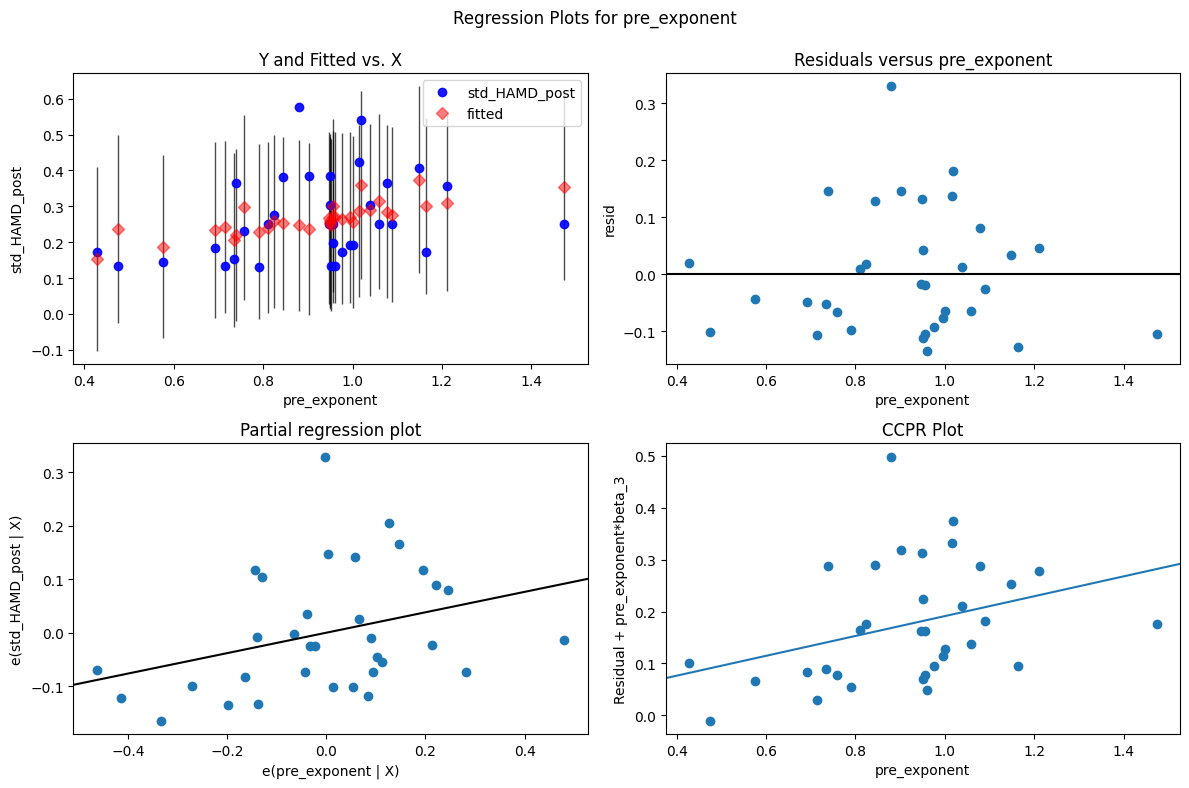

In [47]:
fig = plt.figure(figsize=(12,8))

fig = sm.graphics.plot_regress_exog(model, 'pre_exponent', fig=fig)

In [52]:
model.get_robustcov_results(cov_type='HC3').summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          std_HAMD_post   R-squared:                       0.151
Model:                            OLS   Adj. R-squared:                  0.067
Method:                 Least Squares   F-statistic:                     1.793
Date:                Tue, 20 Jun 2023   Prob (F-statistic):              0.170
Time:                        13:19:36   Log-Likelihood:                 27.933
No. Observations:                  34   AIC:                            -47.87
Df Residuals:                      30   BIC:                            -41.76
Df Model:                           3                                         
Covariance Type:                  HC3                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   -0.0746      0.181     -0.412      0.683      -0.444       0.295
C(treatment_type)[T.MST]     0.0429      0.059      0.732      0.470      -0.077       0.163
std_HAMD_pre                 0.3466      0.329      1.053      0.301      -0.325       1.019
pre_exponent                 0.1912      0.089      2.138      0.041       0.009       0.374
==============================================================================
Omnibus:                        8.071   Durbin-Watson:                   1.945
Prob(Omnibus):                  0.018   Jarque-Bera (JB):                6.691
Skew:                           1.022   Prob(JB):                       0.0352
Kurtosis:                       3.739   Cond. No.                         23.2
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
"""

eval_env: 1


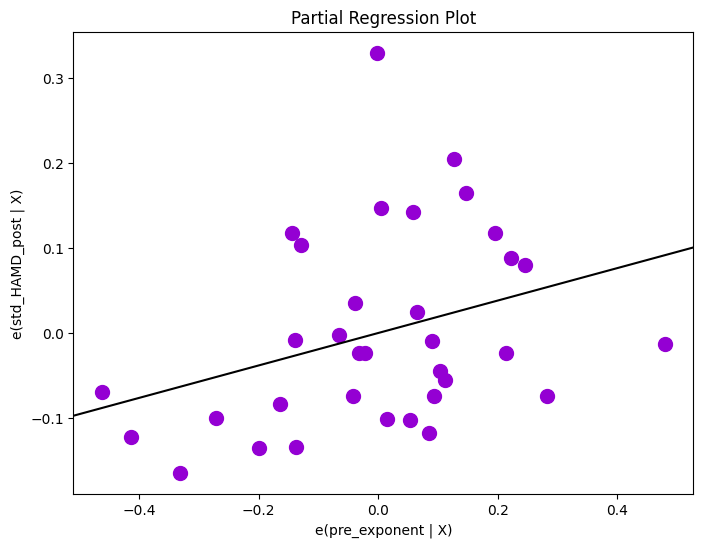

In [62]:
ect_mst_clin_eeg_df_nonan = pd.DataFrame(ect_mst_clin_eeg_df[ect_mst_clin_eeg_df['std_HAMD_post'].notna()])

fig, ax = plt.subplots(figsize=(8,6))
fig, coords = sm.graphics.plot_partregress(endog="std_HAMD_post", exog_i="pre_exponent", exog_others=["std_HAMD_pre", 'C(treatment_type)'],
                             data=ect_mst_clin_eeg_df_nonan, obs_labels=False, color='darkviolet', ax=ax, markersize=10, ret_coords=True);


In [66]:
ect_mst_clin_eeg_df_nonan['coord_x'] = coords[0]
ect_mst_clin_eeg_df_nonan['coord_y'] = coords[1]

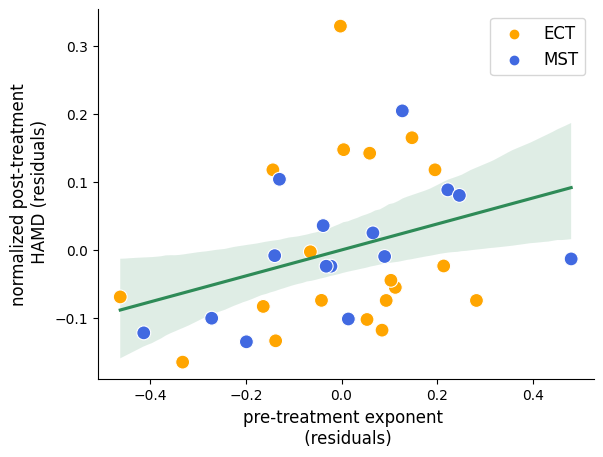

In [94]:
color_dict = {'ECT':'orange',
              'MST': 'royalblue'}

sns.regplot(data=ect_mst_clin_eeg_df_nonan, x='coord_x', y='coord_y', color='seagreen')
sns.scatterplot(data=ect_mst_clin_eeg_df_nonan, x='coord_x', y='coord_y', hue='treatment_type',
                palette=color_dict, s=100)

plt.xlabel('pre-treatment exponent \n (residuals)', size=12)
plt.ylabel('normalized post-treatment\n HAMD (residuals)', size=12)
# plt.title('', size=25)
ax.tick_params(axis='both', labelsize=20)
plt.legend(title='', fontsize=12)
sns.despine()
# plt.show()

# Difference in baseline exponent ECT & MST 

In [37]:
ttest(mst_clin_eeg_df['pre_exponent'], ect_clin_eeg_df['pre_exponent'])

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,1.382286,42.495406,two-sided,0.174106,"[-0.04, 0.21]",0.412816,0.634,0.272548


In [38]:
sns.set_context('notebook')

Text(0.5, 0, 'baseline exponent')

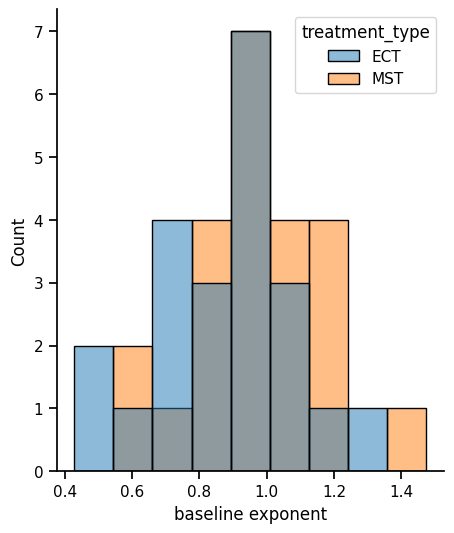

In [39]:
plt.figure(figsize=[5,6])
sns.histplot(ect_mst_clin_eeg_df, x='pre_exponent', hue='treatment_type')
sns.despine()
plt.xlabel('baseline exponent')

# Relationship between difference in exponent and number of treatments received

## ECT

/Users/sydneysmith/opt/anaconda3/envs/mst-ect/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


,n,r,CI95%,p-val,BF10,power
pearson,19,-0.536577,"[-0.8, -0.11]",0.017858,3.865,0.688058


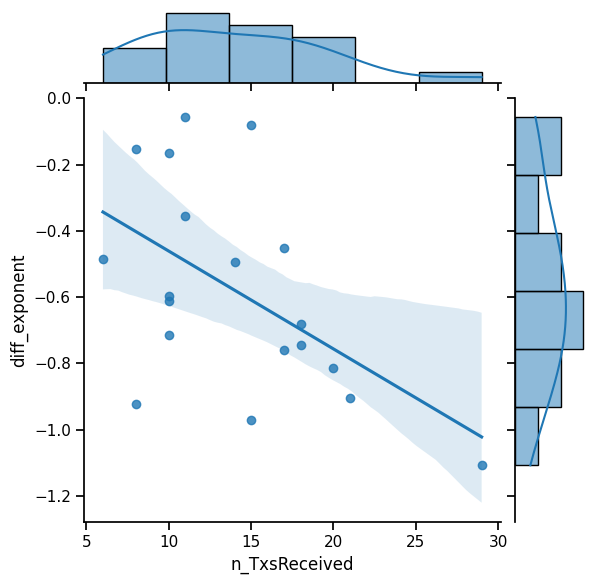

In [40]:
x = ect_clin_eeg_df['n_TxsReceived']
y = ect_clin_eeg_df['diff_exponent']

sns.jointplot(x, y, kind="reg")

corr(x,y)

## MST

/Users/sydneysmith/opt/anaconda3/envs/mst-ect/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


,n,r,CI95%,p-val,BF10,power
pearson,23,0.01172,"[-0.4, 0.42]",0.957673,0.259,0.049672


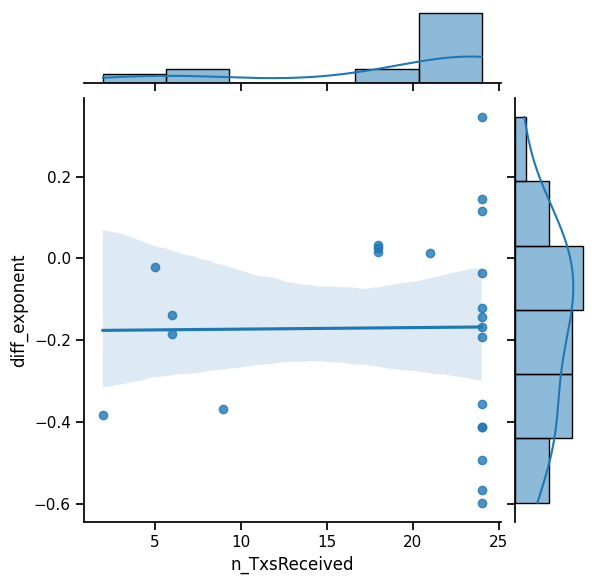

In [41]:
x = mst_clin_eeg_df['n_TxsReceived']
y = mst_clin_eeg_df['diff_exponent']

sns.jointplot(x, y, kind="reg")

corr(x,y)

In [42]:
ect_mst_clin_eeg_df[['patient', 'treatment_type', 'diff_theta_cf']]

,patient,treatment_type,diff_theta_cf
0,3,ECT,0.498191
1,4,ECT,0.728374
2,10,ECT,0.864910
3,13,ECT,-0.287061
4,16,ECT,0.826101
5,18,ECT,NaN
6,19,ECT,-0.479380
7,25,ECT,0.733550
8,29,ECT,-1.199892
9,31,ECT,0.692422
